# The aproach makes use of transfer-learning . The model used here is VGG16 model which was pre-trained on image-net. In addition to this, a shallow CNN is also used which is then concatenated with the VGG16. This combined model is trained on the current dataset while not retraining the VGG16. Initially, I thought json data could also be used as an addtional input to the architecture (in that case parallel layers could have been concatenated, i.e. VGG16 + Shallow CNN + the parallel model for json). But, the problem with json file was that ,for all the images, words like "pav bhaji","#pav-bhaji" were present in the caption even for the non-paav bhaji images. Therefore, in the end, just the image has been solely used for the clssification task and was able to achieve F1 score of .8. Stratified sampling was also used to account for the imbalance in the class distribution.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import datetime
import os
import cv2
import json
import pprint
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Add, Input, Concatenate
from keras import backend as K
from keras.layers import Input
import tensorflow as tf
import keras
from keras import backend as K 
K.clear_session()
np.random.seed(42)

Using TensorFlow backend.


In [2]:
#extracting the file names of the images in the respective folders
one_files=os.listdir("./1")
zero_files=os.listdir("./0")

In [3]:
from keras.applications.vgg16 import VGG16

## the following code processes the images and scales them to a size that can fit in 300X300 resolution and pads the resized images wherever necessary

In [4]:
desired_size=300
total_data_x=np.zeros((len(one_files+zero_files),desired_size,desired_size,3))    
total_data_y=np.zeros((len(one_files+zero_files),1))    
count=0
for fil in one_files:
    if(fil.split(".")[-1]=="jpg"):
        file="./1/"+fil
    if(count==y_pred.shape
        im = cv2.imread(file)
        old_size = im.shape[:2] # old_size is in (height, width) format
        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])
        im = cv2.resize(im, (new_size[1], new_size[0]))
        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        #rgb value for padding
        color = [0, 0, 0]
        new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
            value=color)
        new_im=cv2.cvtColor(new_im, cv2.COLOR_BGR2RGB)
        #normalizing pixel values to bring it in a range of [0,1]
        total_data_x[count,:,:,:]=new_im/255.00
        total_data_y[count,0]=1
        count+=1
    

for fil in zero_files:
    if(fil.split(".")[-1]=="jpg"):
        file="./0/"+fil
        im = cv2.imread(file)
        old_size = im.shape[:2] # old_size is in (height, width) format
        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])
        im = cv2.resize(im, (new_size[1], new_size[0]))
        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        #rgb value for padding
        color = [0, 0, 0]
        new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
            value=color)
        new_im=cv2.cvtColor(new_im, cv2.COLOR_BGR2RGB)
        #normalizing pixel values to bring it in a range of [0,1]
        total_data_x[count,:,:,:]=new_im/255.00
        total_data_y[count,0]=0
        count+=1

In [5]:
total_data_x.shape

(452, 300, 300, 3)

## The following plot shows an imbalance in the class which is quite significant for such a small dataset

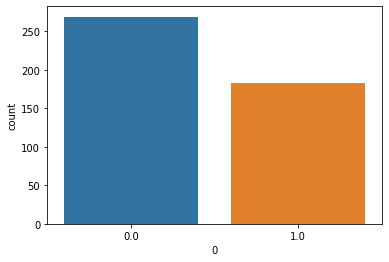

In [6]:
ax = sns.countplot(x=0, data=pd.DataFrame(total_data_y))

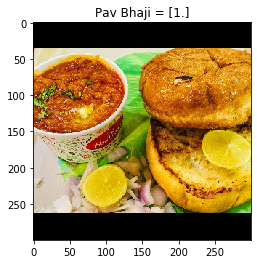

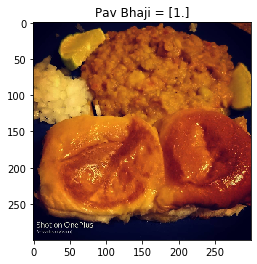

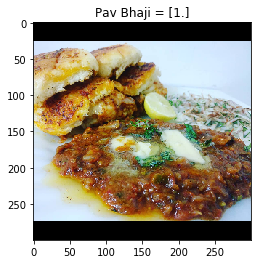

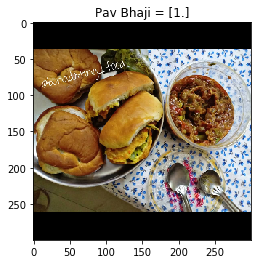

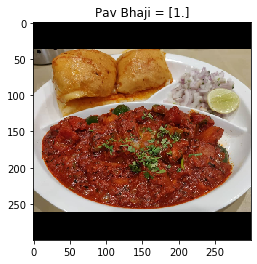

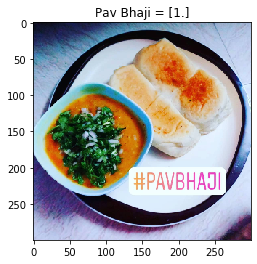

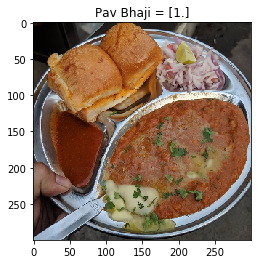

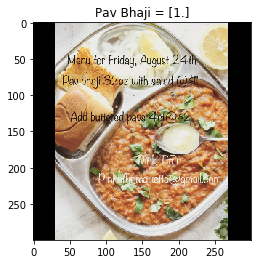

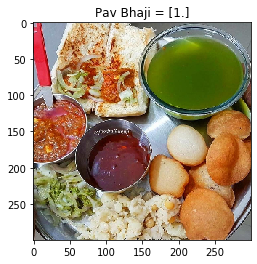

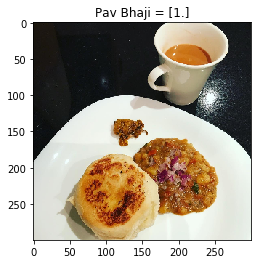

In [7]:
for i in range(10):
    plt.figure(i+1)
    plt.title("Pav Bhaji = "+str(total_data_y[i]))
    plt.imshow(total_data_x[i,:,:,:])

## The following code splits the data into test,train and valid sets. Stratification is also used in this process

In [8]:
remaining_X, validX, remaining_Y, validY = train_test_split(total_data_x, total_data_y,stratify=total_data_y,  test_size=0.10, random_state=42)
trainX, testX, trainY,testY = train_test_split(remaining_X, remaining_Y,stratify=remaining_Y,  test_size=0.33, random_state=42)

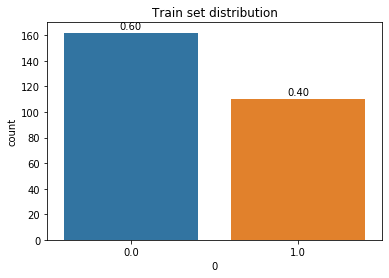

In [9]:
ax = sns.countplot(x=0, data=pd.DataFrame(trainY))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(trainY))),
            ha="center") 
plt.title("Train set distribution")
plt.show()

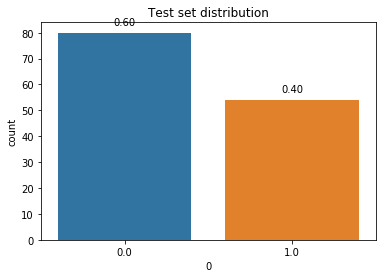

In [10]:
ax = sns.countplot(x=0, data=pd.DataFrame(testY))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(testY))),
            ha="center") 
plt.title("Test set distribution")
plt.show()

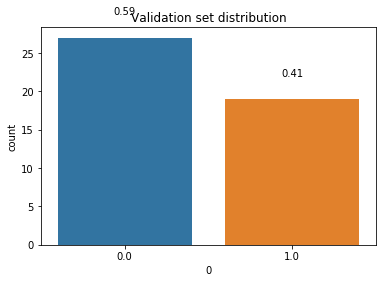

In [11]:
ax = sns.countplot(x=0, data=pd.DataFrame(validY))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(validY))),
            ha="center") 
plt.title("Validation set distribution")
plt.show()

In [12]:
#this part of code is used for data augmentation
gen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.1,
                             height_shift_range=0.1,rescale=1/255.)



In [13]:
filepath = '/home/shubham/Downloads/pavbhaji/models/' + "-saved-model-{epoch:02d}-{accuracy:.2f}.hdf5"


## the following code is the backbone for building and training the neural net architecture

In [14]:
checkpoints = keras.callbacks.ModelCheckpoint(filepath,
                                                    monitor='val_loss',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='min')
# Configurations
NUM_WORKERS = 4 
BATCH_SIZE = 10
NUM_EPOCHS = 20 

inputs = Input(shape=(desired_size, desired_size, 3))
base_model = VGG16(weights='imagenet', include_top=False,input_shape=(desired_size, desired_size,3))
#shallow CNN starts here
x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu', input_shape=(desired_size, desired_size, 3))(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)

x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)(x)
x = Flatten()(x)
#shallow CNN ends here
base = base_model(inputs)
base = Flatten()(base)
#models are combined
concated_layers = Concatenate()([x, base])

concated_layers = Dense(200, activation='relu')(concated_layers)
predictions = Dense(1, activation='sigmoid')(concated_layers)

# model to be trained
model = Model(inputs=inputs, outputs=predictions)

#freeze all the weights of VGG16
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=["accuracy"])

for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

# train the model on the new data for a few epochs
model.fit_generator(gen.flow(trainX, trainY, batch_size=BATCH_SIZE),validation_data=(testX, testY), steps_per_epoch=len(trainY) // BATCH_SIZE,epochs=NUM_EPOCHS,
 workers=NUM_WORKERS,use_multiprocessing=True,verbose=1,callbacks=[checkpoints])



0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
Epoch 1/100
27/27 [==============================] - 20s 733ms/step - loss: 15.0902 - accuracy: 0.5344 - val_loss: 1.4078 - val_accuracy: 0.4328

Epoch 00001: val_loss improved from inf to 1.40779, saving model to /home/shubham/Downloads/pavbhaji/models/-saved-model-01-0.53.hdf5
Epoch 2/100
27/27 [==============================] - 15s 538ms/step - loss: 1.1684 - accuracy: 0.5840 - val_loss: 0.5443 - val_accuracy: 0.7015

Epoch 00002: val_loss improved from 1.40779 to 0.54428, saving model to /home/shubham/Downloads/pavbhaji/models/-saved-model-02-0.58.hdf5
Epoch 3/100
27/27 [==============================] - 19s 703ms/step - loss: 0.6542 - accuracy: 0.7023 - val_loss: 0.5083 - val_accuracy: 0.7313

Epoch 00

Process ForkPoolWorker-63:
Process ForkPoolWorker-64:
Traceback (most recent call last):
Process ForkPoolWorker-62:
  File "/home/shubham/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkPoolWorker-61:
Traceback (most recent call last):
  File "/home/shubham/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shubham/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/shubham/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shubham/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shubham/anaconda3/lib/python3.7/site-packages/keras/utils/data_utils.py", line 406, in get_index
    re

KeyboardInterrupt: 

Process ForkPoolWorker-68:
Process ForkPoolWorker-67:
Process ForkPoolWorker-66:
Process ForkPoolWorker-65:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shubham/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/shubham/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/shubham/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/shubham/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/shubham/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shubham/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shubham/

In [22]:
print("loss and binary accuracy : ")
print(model.evaluate_generator(gen.flow(validX,validY,batch_size=BATCH_SIZE,seed=42), workers=NUM_WORKERS,use_multiprocessing=True))


loss and binary accuracy : 
[0.7640798091888428, 0.8260869383811951]


## giving the f1 score on the validation set

In [19]:
y_pred=model.predict_generator(gen.flow(validX,validY,batch_size=BATCH_SIZE,seed=42), workers=NUM_WORKERS,use_multiprocessing=True)
count=0
y_true=[]
for i in gen.flow(validX,validY,batch_size=BATCH_SIZE,seed=42):
    count+=i[1].shape[0]
    for j in i[1]:
        #print(j)
        y_true.append(j)
    if(count==y_pred.shape[0]):
        break;
y_true=np.array(y_true)
for i in range(y_pred.shape[0]):
    if y_pred[i]>=.50:
        y_pred[i]=1
    else:
        y_pred[i]=0
print("F1 score on validation set is: ",str(sklearn.metrics.f1_score(y_true, y_pred)))

F1 score on validation set is:  0.8


## the following code was used to see if there's anything that is present in the json file that can be used to provide additional information to the architecture. Words like "paav bhaji" in the caption were to be seen as a positive feature but since these types of words are present in both types, positive and negative,this approcah couldn't be used. 

In [20]:
all_ids=[]

def extract_json_all(data_folder="./"):
    #extract all the file names
    files=os.listdir(data_folder)
    #list to store json object
    json_data={}
    file="pavbhaji.json"
    search=0
    count=0
    with open(data_folder+file) as f:
        temp=json.loads(f.read())
        print("\n\n\n")
        for i in temp:
            #pprint.pprint(i)
            pav=["paav-bhaji","paavbhaji","paav bhaji","pav bhaji","pav-bhaji","pavbhaji","pav bhagi","pav-bhagi","pavbhagi","paav bhagi","paav-bhagi","paavbhagi"]
            if "tags" in i.keys():
                
                s1=set(pav)
                s2=set(i["tags"])
                ans=s1.intersection(s2)
                if ans!=set():
                    search=1
            if 'edge_media_to_caption' in i.keys():
                #print(i['edge_media_to_caption']["edges"])
                if i['edge_media_to_caption']["edges"]!=[]:
                    text=i['edge_media_to_caption']["edges"][0]["node"]["text"].lower()
                    for p in pav:
                        if text.find(p):
                            search=1
                            break
            id_pic=i["display_url"].split("/")[-1]
            all_ids.append(id_pic)
            print(id_pic," ",str(search))
            count+=1
    print(count)

extract_json_all()    





37599530_291077411445016_3382263118984904704_n.jpg   1
36848355_187489742110497_7922878806031859712_n.jpg   1
38618276_2089245347991843_6362789531271299072_n.jpg   1
36984232_209033119813457_5512235609793495040_n.jpg   1
39276567_1342282245902379_3421591176736669696_n.jpg   1
37036628_270418473752731_596743572150026240_n.jpg   1
37789475_240451653272538_5032156680981315584_n.jpg   1
39783672_535904726841494_48958405221548032_n.jpg   1
38469052_1161373754002065_8060020189455692453_n.jpg   1
39134930_335164943725203_1821110887063224320_n.jpg   1
39140810_2032390520165251_1873473414644105216_n.jpg   1
39141696_270924236850550_5447694934373040128_n.jpg   1
40061401_397177667478885_8004639220817723392_n.jpg   1
39746049_290439278406280_7840588117403762688_n.jpg   1
39913452_2166586706748398_8840015565390086144_n.jpg   1
39287793_1762674650482819_7298691904688881664_n.jpg   1
39582193_443722342805398_7742986819553198080_n.jpg   1
39790065_708138802879611_4373499256883904512_n.jpg   1
392

38215582_1127660660736358_2122694673020485632_n.jpg   1
37937058_265591514238338_8212473040458481664_n.jpg   1
37895388_902194459968225_4808393639388512256_n.jpg   1
38493912_1810428235672618_3572466046335975424_n.jpg   1
37748092_245461116110115_5732392867427516416_n.jpg   1
38906667_270360737079855_1941493309927063552_n.jpg   1
37982634_1896381120667326_2404238996273102848_n.jpg   1
37990391_199692147571073_4626842245050400768_n.jpg   1
38097614_2612172485675012_5977969790218665984_n.jpg   1
38097602_274772729776681_5518974718423597056_n.jpg   1
37917792_688044238242674_8109442878175969280_n.jpg   1
38957751_1014610725382804_5449102721573453824_n.jpg   1
37950026_366712527197982_1078477184357629952_n.jpg   1
38184084_1000271213488305_4601556930765258752_n.jpg   1
38465759_644584439260514_8547260711774978048_n.jpg   1
38258407_1709523605812190_6567561606165692416_n.jpg   1
38795126_287292881854271_5613041219534848_n.jpg   1
38535245_1984317605193337_519447784458289152_n.jpg   1
378625

In [21]:
len(set(all_ids).intersection(set(zero_files)))

269